# Lid-driven cavity flow
In this notebook we will simulate the flow in a square cavity with a top moving wall.

In [1]:
using ViscousFlow

In [2]:
using Plots

## Problem specification
Take $Re=100$ for example:

In [3]:
my_params = Dict()
my_params["Re"] = 100

100

## Discretization
Note that the rectangle function used for making the cavity shape requires a specified half length. The
immersed boundary projection method for internal flow requires the size of the domain to
be at least a step size greater at the boundaries (i.e. `halflength + Δx`).
So, for safety we make it 2 percent greater on each side.

Also, we set the grid Reynolds number to 0.5, lower than default of 2, so we have more
accuracy. We also set the CFL number to 1.0, larger than the default of 0.5, so we
can get to steady state faster.

In [4]:
halflength=0.5
domain_lim=1.02*halflength
xlim, ylim = (-domain_lim,domain_lim),(-domain_lim,domain_lim)
my_params["grid Re"] = 0.5
my_params["CFL"] = 1.0
g = setup_grid(xlim,ylim,my_params)

Δs = surface_point_spacing(g,my_params)

0.006999999999999999

## Cavity Geometry
A square cavity can be created using the `Rectangle()` function with the half length defined above.
We place its center at the origin.

In [5]:
body = Rectangle(halflength,halflength,Δs)
X = MotionTransform([0.0,0.0],0.0)
joint = Joint(X)
m = RigidBodyMotion(joint,body)
x = init_motion_state(body,m)
update_body!(body,x,m)

Closed polygon with 4 vertices and 572 points
   Current position: (0.0,0.0)
   Current angle (rad): 0.0


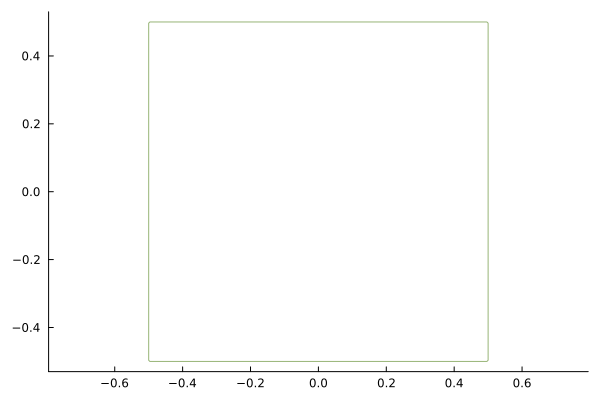

In [6]:
plot(body,fillrange=nothing)

## Boundary Condition at the moving wall
Assign velocity to the top boundary (in the interior of the square). To do this,
we redefine the interior boundary condition function (the "interior" key of
the bc dictionary). We don't have to touch the exterior boundary condition,
because it defaults to zero, as we desire.

Rectangles and other polygon shapes in the `RigidBodyTools.jl`
package have a `side` field that allows easy access to the index range
for each side. Here, we use that feature to set the $x$ velocity
along the top to 1. We also use the `view` function to provide access
to the part of the overall velocity vector associated with body 1. That's
not particularly important in this example, since there is only one body,
but it is useful in problems that have multiple bodies.

In [7]:
function my_vsminus(t,x,base_cache,phys_params,motions)
  vsminus = zeros_surface(base_cache)
  vsu = view(vsminus.u,base_cache,1)

  top = base_cache.bl[1].side[3]
  vsu[top] .= 1.0
  return vsminus
end

bcdict = Dict("interior" => my_vsminus)

Dict{String, typeof(Main.var"##580".my_vsminus)} with 1 entry:
  "interior" => my_vsminus

## Construct the system structure
Now we provide our parameters and the boundary condition dictionary.

In [8]:
sys = viscousflow_system(g,body,phys_params=my_params,bc=bcdict,motions=m);

Initialize

In [9]:
u0 = init_sol(sys)

(Dual nodes in a (nx = 212, ny = 206) cell grid of type Float64 data
  Number of Dual nodes: (nx = 212, ny = 206), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

Set up integrator

In [10]:
tspan = (0.0,10.0)
integrator = init(u0,tspan,sys)

t: 0.0
u: (Dual nodes in a (nx = 212, ny = 206) cell grid of type Float64 data
  Number of Dual nodes: (nx = 212, ny = 206), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0])

## Solve
For demonstration purposes, we run this over 2 convective time units. (You can run it longer to get it
to steady state.)

In [11]:
step!(integrator,2)

## Examine
Plot the vorticity and streamlines. We take a little care with the
streamlines to show the small recirculation zones in the lower corners.

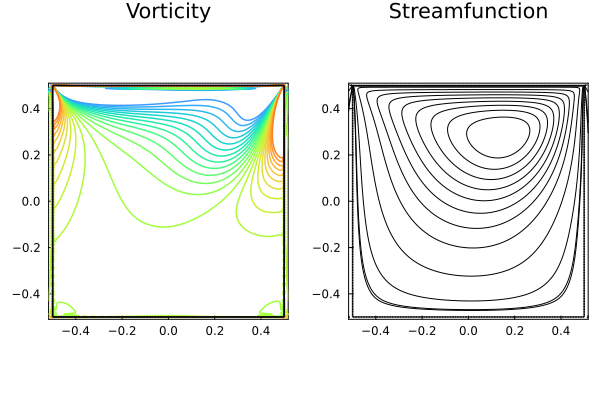

In [12]:
mins, maxs = extrema(streamfunction(integrator))
slevs = vcat(range(mins,maxs,length=11),maxs-0.00438,maxs-0.00353,maxs-0.00348)
plot(
plot(vorticity(integrator),sys,title="Vorticity",clim=(-10,10),color=:turbo,linewidth=1.5,ylim=ylim,levels=-6:0.5:5),
plot(streamfunction(integrator),sys,title="Streamfunction",color=:black,ylim=ylim,levels=slevs)
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*